In [34]:
from sirpy.models.SIR import SIR
import pandas as pd
from LeastSquaresTrainer import LeastSquaresTrainer
import numpy as np
from abstractModel import EmptyModel
from abstractModel import State, Transition
from sirpy.metrics.MetricsFuns import RMSE, MAE, MSE

In [35]:
data = pd.read_csv("test_data/chileconvacunas.csv", index_col=0, parse_dates=True)
data.head()

,sintomaticos,Cases,Deaths,Vacunados,Efectividad,refuerzo,Efe refuerzo
Totales,,,,,,,
2020-04-01,293,3030,16,0,0.0,0,0.0
2020-04-02,373,3403,18,0,0.0,0,0.0
2020-04-03,333,3736,22,0,0.0,0,0.0
2020-04-04,424,4160,27,0,0.0,0,0.0
2020-04-05,310,4470,34,0,0.0,0,0.0


In [36]:
# DICIEMBRE+ENERO
t0 = '2020-12-01'
tf = '2021-01-31'
tval = '2021-02-01'
tpred = '2021-02-07'

In [37]:
data_tr = data[t0:tf]
data_val = data[tf:tval]
data_pred = data[t0:tpred]

# tiempo de entreno
T = np.arange(0, len(data_tr))
# tiempo de validacióin
T_val = np.arange(len(data_tr), len(data_tr)+len(data_val))
# tiempo de predicción
T_pred = np.arange(0, len(data_pred))

In [38]:
data_tr

,sintomaticos,Cases,Deaths,Vacunados,Efectividad,refuerzo,Efe refuerzo
Totales,,,,,,,
2020-12-01,747,410493,15430,0,0.000000,0,0.0
2020-12-02,773,411266,15438,0,0.000000,0,0.0
2020-12-03,1079,412345,15519,0,0.000000,0,0.0
2020-12-04,1155,413500,15558,0,0.000000,0,0.0
2020-12-05,1014,414514,15592,0,0.000000,0,0.0
...,...,...,...,...,...,...,...
2021-01-27,2423,514926,18040,10408,0.434798,0,0.0
2021-01-28,2896,517822,18174,10408,0.475687,0,0.0
2021-01-29,2941,520763,18257,10413,0.516328,0,0.0


In [39]:
# Take Cases and Deaths in one dataframe
data_tr_2 = data_tr[['Cases', 'Deaths']].to_numpy()
data_val_2 = data_val[['Cases', 'Deaths']].to_numpy()

In [40]:
cmm = EmptyModel(
  name = "CMM",
  hyper_params={
    "time_space": (0, T.max()),
    "time_range": T,
    "test_time_space": (len(data_tr), len(data_tr)+len(data_val)),
    "test_time_range": T_val
  },
  train_params={
      "gamma_a": 0.5,
      "gamma_s": 0.5,
      "beta_a": 0.5,
      "beta_s": 0.5,
      "delta": 0.5,
      "q_a": 1 / 480,
      "q_s": 1 / 480,
      "ut": 0.5,
      "mu": 0.5,
      "p": 0.3,

  },
  static_params={
      "initial_condition": np.array([1 - 1e-3, 1e-3, 0, 0, 0, 0,])
  }
)

cmm.add_states([
    State("S"), # Susceptible
    State("I_a"), # Infected asymptomatic
    State("I_s"), # Infected symptomatic
    State("R_a"), # Recovered asymptomatic
    State("R_s"), # Recovered symptomatic
    State("D"), # Dead
])

calculate_N = lambda t, y, p: y.S + y.I_a + y.I_s + y.R_a + y.R_s
lamdba = lambda t, y, p: ((1-p.ut)*p.beta_a*y.I_a+(1-p.mu)*(p.beta_s*y.I_s))*y.S

cmm.add_transition(
    Transition(
        name="S -> I_a",
        left="S",
        right="I_a",
        fun= lambda t, y, p: lamdba(t, y, p),
        symmetrical=False
    )
)

cmm.add_transition(
    Transition(
        name="S -> I_a",
        left="I_a",
        right="S",
        fun= lambda t, y, p: - p.p * lamdba(t, y, p),
        symmetrical=False
    )
)

cmm.add_transition(
    Transition(
        name="S -> I_a",
        left="I_s",
        right="S",
        fun= lambda t, y, p: - (1 - p.p) * lamdba(t, y, p),
        symmetrical=False
    )
)

cmm.add_transition(
    Transition(
        name="R_a -> S",
        left="R_a",
        right="S",
        fun= lambda t, y, p: p.q_a*y.R_a,
    )
)

cmm.add_transition(
    Transition(
        name="R_s -> S",
        left="R_s",
        right="S",
        fun= lambda t, y, p: p.q_s*y.R_s,
    )
)

cmm.add_transition(
    Transition(
        name="I_a -> R_a",
        left="I_a",
        right="R_a",
        fun= lambda t, y, p: p.gamma_a * y.I_a,
    )
)

cmm.add_transition(
    Transition(
        name="I_s -> R_s",
        left="I_s",
        right="R_s",
        fun= lambda t, y, p: p.gamma_s * y.I_s,
    )
)


cmm.add_transition(
    Transition(
        name="I_s -> D",
        left="I_s",
        right="D",
        fun= lambda t, y, p: p.delta * y.I_s,
    )
)
cmm.train_data = data_tr_2
cmm.test_data = data_val_2

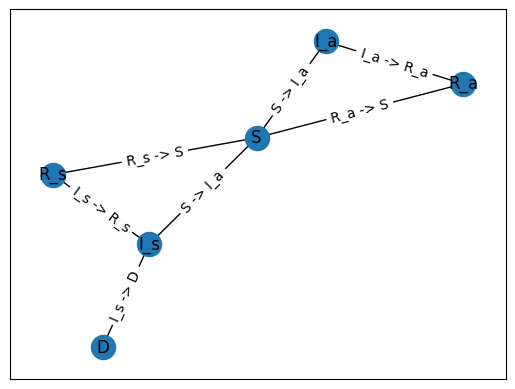

In [41]:
cmm.plot_model()

In [42]:
#TODO: Graficos de residuos (Scatter plot)
def another_residual_fun(x, trainer_):
    """
    This is an example of another residual function that only uses the cases data and death
    to adjust the parameters.
    """
    trainer_.model.set_train_params_from_list(x)
    # take the same amount of columns of the train data
    y_pred = trainer_.calculate_curves()
    y_pred = np.stack([y_pred[:,-1], y_pred[:,-2]], axis=1)
    diff = trainer_.model.train_data[0:y_pred.shape[0],:] - y_pred
    return diff.flatten()


In [43]:
trainer = LeastSquaresTrainer(cmm,)
trainer.residual_fun = another_residual_fun

In [44]:
trainer.compute_gradients(0, cmm.p("initial_condition"))

array([[-0.00024975],
       [-0.00042508],
       [ 0.00017483],
       [ 0.0005    ],
       [ 0.        ],
       [ 0.        ]])

In [45]:
trainer.train(verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.5300e+12                                    2.66e+04    
       1              2         6.5299e+12      9.26e+07       1.36e+00       1.16e+10    
       2              3         6.3915e+12      1.38e+11       2.71e+00       1.98e+07    


KeyboardInterrupt: 